<a href="https://colab.research.google.com/github/sfansaria/Machine-Learning/blob/main/Simple_Bayesian_LInear_Regression_TensorFlow_Probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
#Import Libraries

import numpy as np
import pandas as pd

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp
tfd = tfp.distributions

In [85]:
#For data visualization

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns

sns.set_style(style='darkgrid',rc={'axes.facecolor': '.9','grid.color': '.8'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

#Get Tensorflow Version
print(f'TensorFlow version: {tf.__version__}')
print(f'TensorFlow Probability version: {tfp.__version__}')

TensorFlow version: 2.13.0
TensorFlow Probability version: 0.20.1


[Text(0.5, 1.0, '$y$ distribution'), Text(0.5, 0, 'y')]

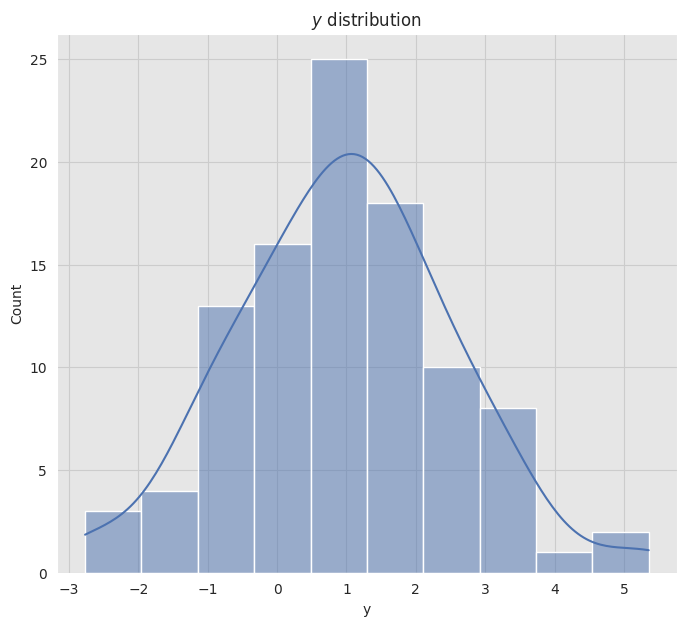

In [86]:
#Generate data
np.random.seed(42)

#True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

#Size of dataset
size = 100

#Predictor variable
x0 = np.random.randn(size)
x1 = np.random.randn(size) * 0.2

#simulate outcome variable
y = alpha + beta[0] * x0 + beta[1] * x1 + np.random.randn(size) * sigma

#let us plot the distribution of the target variable
fig, ax = plt.subplots(figsize=(8,7))
sns.histplot(x=y, kde=True, ax=ax)
ax.set(title='$y$ distribution', xlabel='y')


[Text(0.5, 1.0, '$x_1$ vs $y$'), Text(0.5, 0, '$x_1$'), Text(0, 0.5, 'y')]

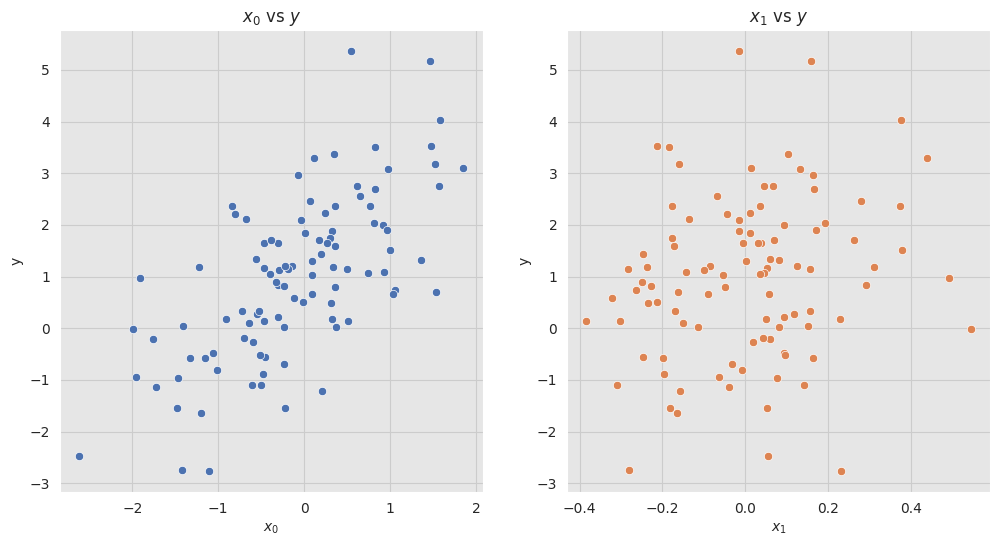

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=2)

sns.scatterplot(x=x0, y=y, color=sns_c[0], ax=ax[0])
sns.scatterplot(x=x1, y=y, color=sns_c[1], ax=ax[1])

ax[0].set(title='$x_0$ vs $y$', xlabel = '$x_0$', ylabel='y')
ax[1].set(title='$x_1$ vs $y$', xlabel = '$x_1$', ylabel='y')

In [88]:
#To define the model in TensorFlow Probability
#convert the input into tf tensors

#set seed
tf.random.set_seed(42)

#set tensor numeric type
dtype = 'float32'

x = np.stack([x0, x1], axis=1)
x = tf.convert_to_tensor(x, dtype=dtype)
y = tf.convert_to_tensor(y, dtype = dtype)
y = tf.reshape(y, (-1, 1))


In [89]:
#define the model distribution using Auto-Batched Joint Distributions

jds_ab = tfd.JointDistributionNamedAutoBatched(dict(sigma=tfd.HalfNormal(scale=[tf.cast(1.0, dtype)]),
                                                    alpha=tfd.Normal(loc=[tf.cast(0.0, dtype)],
                                                    scale=[tf.cast(10.0, dtype)]),
                                                    beta = tfd.Normal(loc=[[tf.cast(0.0, dtype)],[tf.cast(0.0, dtype)]],scale=[[tf.cast(10.0, dtype)],[tf.cast(10.0, dtype)]]),
                                                    y=lambda beta, alpha, sigma: tfd.Normal(loc=tf.linalg.matmul(x, beta) + alpha, scale=sigma)))


In [90]:
#Prior Simulations

#Generate predictions with the prior distributions

#sample from the prior

prior_samples = jds_ab.sample(500)['y']


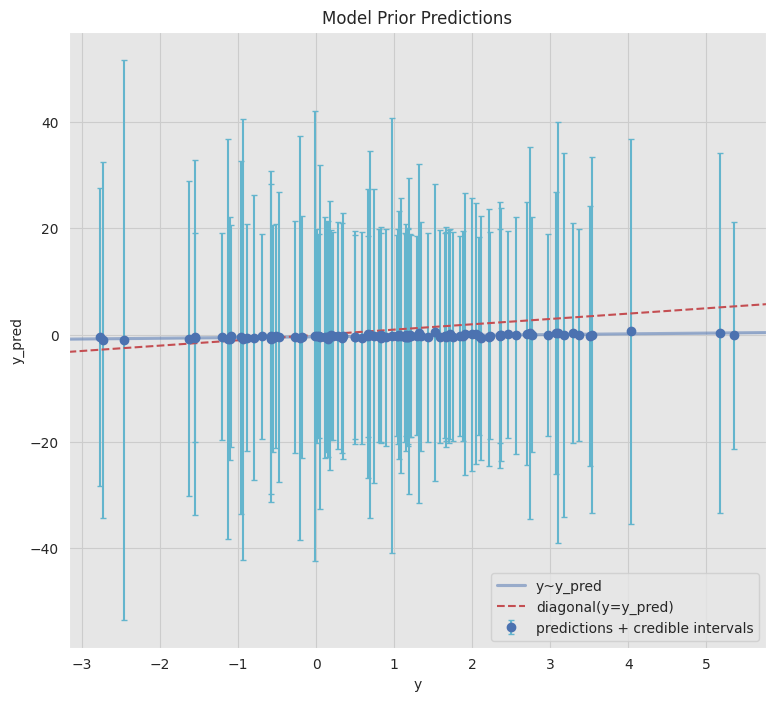

In [91]:
#plot the predictions against the true values of y
# with the corresponding credible interval (μ±2σ).

prior_samples = tf.squeeze(prior_samples)
prior_mean = tf.math.reduce_mean(prior_samples, axis=0).numpy()
prior_std = tf.math.reduce_std(prior_samples, axis=0).numpy()

fig, ax = plt.subplots(figsize=(9,8))

ax.errorbar(x=tf.squeeze(y).numpy(), y=prior_mean, yerr = 2*prior_std, fmt = 'o', ecolor=sns_c[9], capsize=2, label='predictions + credible intervals')

sns.regplot(x=tf.squeeze(y).numpy(), y=prior_mean, color=sns_c[0], scatter = False, line_kws = dict(alpha=0.5),label='y~y_pred',truncate=False, ax=ax)

ax.axline(xy1=(0,0), slope=1, linestyle='--', color=sns_c[3], label='diagonal(y=y_pred)')

ax.legend(loc='lower right')

ax.set(title='Model Prior Predictions', xlabel='y',ylabel='y_pred');

In [92]:
#The priors are very flat and the range for predictions is very wide
#In many applications one would like to restrict the priors a little bit more to
#encode domain knowledge information

#To fit the model use Hamiltonian Monte Carlo algorithm
#define the target function
 # in this case is simply the log-probabilty

def target_log_prob_fn(beta=beta, alpha=alpha, sigma=sigma):
    return jds_ab.log_prob(beta=beta, alpha=alpha, sigma=sigma, y=y)



In [93]:
#specify the sampling method

#size of each chain
num_results = int(1e4)

#Burn-in-steps
num_burnin_steps = int(1e3)

#Hamiltonian Monte Carlo Transition Kernel
#In TFP a Transition Kernel returns a new state given some old state.

hcm_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=1.0,
    num_leapfrog_steps=3)

#THis adapts the inner kernel's step_size
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=hcm_kernel,
    num_adaptation_steps=int(num_burnin_steps*0.8))

#Run the chain(with burn-in)
@tf.function
def run_chain():
    #Implement MCMC via repeated TransitionKernel steps
    samples, is_accepted = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=[
            tf.convert_to_tensor([[1.0], [1.0]],dtype=dtype),
            tf.convert_to_tensor([1.0], dtype=dtype),
            tf.convert_to_tensor([1.0], dtype=dtype)],
            kernel = adaptive_hmc,
            trace_fn = lambda _, pkr: pkr.inner_results.is_accepted)

    return samples


In [94]:
#Run the sampling 5 times

#set the number of chains
num_chains = 5
#Run sampling
chains = [run_chain() for i in range(num_chains)]


In [95]:
#Visualize Posterior Distributions

chains_t = list(map(list, zip(*chains)))

chains_samples = [tf.squeeze(tf.concat(samples, axis=0)) for samples in chains_t]

chains_df = pd.concat(objs=[pd.DataFrame(samples.numpy()) for samples in chains_samples], axis=1)

params = ['beta_0', 'beta_1', 'alpha', 'sigma']

chains_df.columns = params

chains_df = chains_df\
    .assign(sample_id = lambda x:range(x.shape[0]),
        chain_sample_id = lambda x: x['sample_id'] % num_results,
        chain_id = lambda x: (x['sample_id']/num_results).astype(int) + 1)\
        .assign(chain_id=lambda x: 'c_' + x['chain_id'].astype(str))\


In [96]:
chains_df.head()

,beta_0,beta_1,alpha,sigma,sample_id,chain_sample_id,chain_id
0,1.230113,2.688856,1.062919,1.016139,0,0,c_1
1,1.239078,2.463629,1.116013,1.067487,1,1,c_1
2,1.213967,2.305331,1.070028,1.183648,2,2,c_1
3,1.245076,1.774402,1.094793,1.071390,3,3,c_1
4,1.166325,1.924036,1.126412,1.101972,4,4,c_1


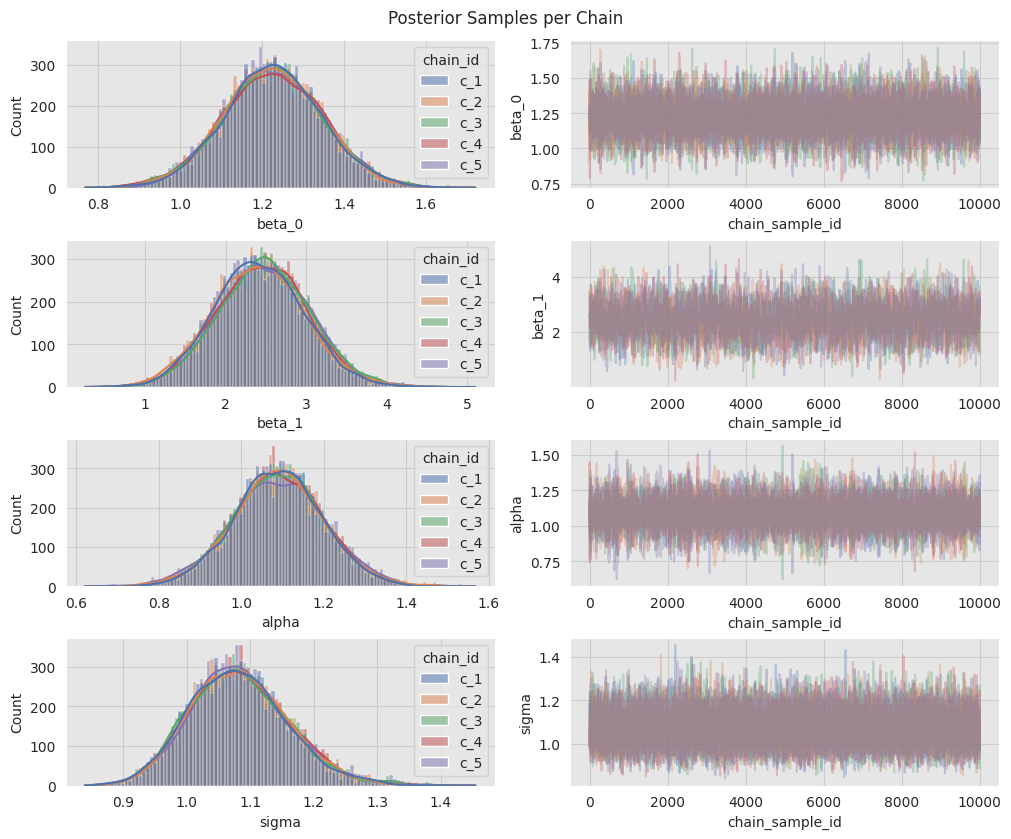

In [97]:
#Plot the Posterior Distributions of the model parameters per chain

fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(10, 8), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0])
    sns.lineplot(x='chain_sample_id', y=param, data= chains_df, hue='chain_id',alpha=0.3, legend=False, ax=axes[i][1])

fig.suptitle('Posterior Samples per Chain', y= 1.03);

Text(0.5, 1.03, 'Posterior Samples')

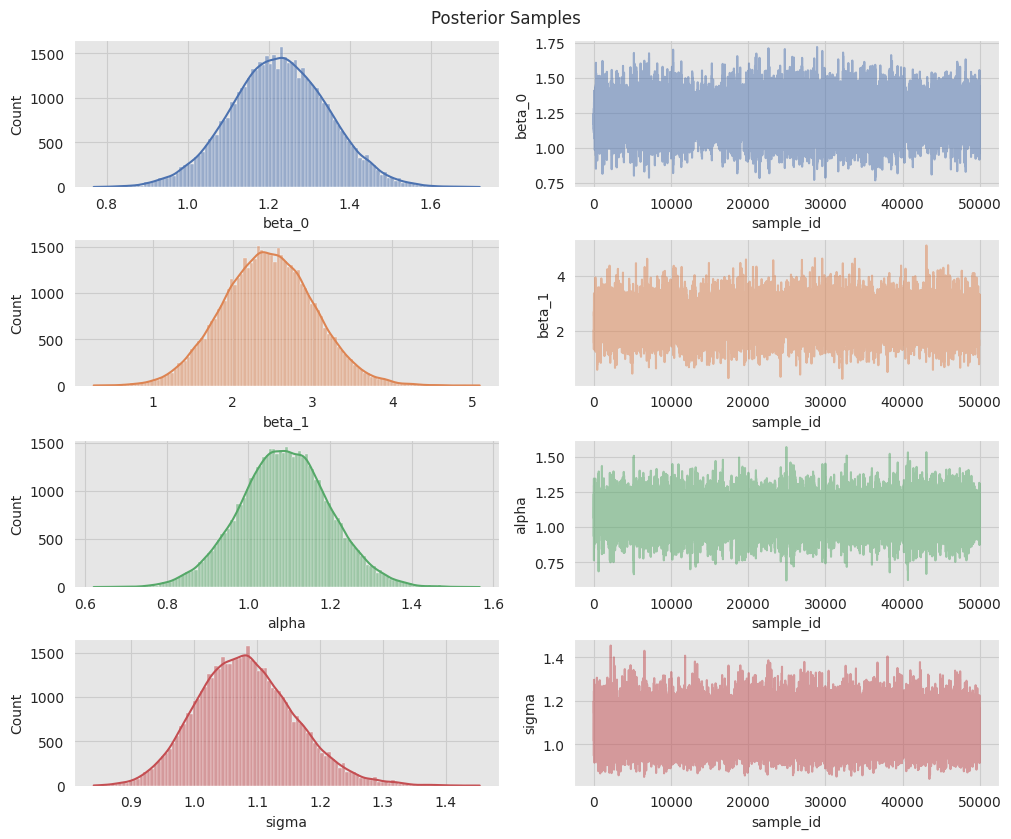

In [98]:
#Generate the sample plot with all the chains combined

fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(10, 8), constrained_layout=True)

for i, param in enumerate(params):
  sns.histplot(x=param, data=chains_df, color=sns_c[i], kde=True, ax=axes[i][0])
  sns.lineplot(x='sample_id', y=param, data=chains_df, color=sns_c[i], alpha=0.5, ax=axes[i][1])

fig.suptitle('Posterior Samples', y=1.03)


In [99]:
#THe chains seems to be converged


In [100]:
#Generate Predictions

#To see the model(in-sample) predictions
#do Sampling from the distribution mean μ (that is, we ignore σ).

#Compute mu = alpha + beta x
mu_posterior_samples = tf.linalg.matmul(tf.reshape(chains_samples[1],(-1, 1)),tf.ones(shape=(1, x.shape[0])))\
               +tf.linalg.matmul(chains_samples[0], tf.transpose(x))


[Text(0.5, 1.0, 'Model Predictions'),
 Text(0.5, 0, 'y'),
 Text(0, 0.5, 'y_pred')]

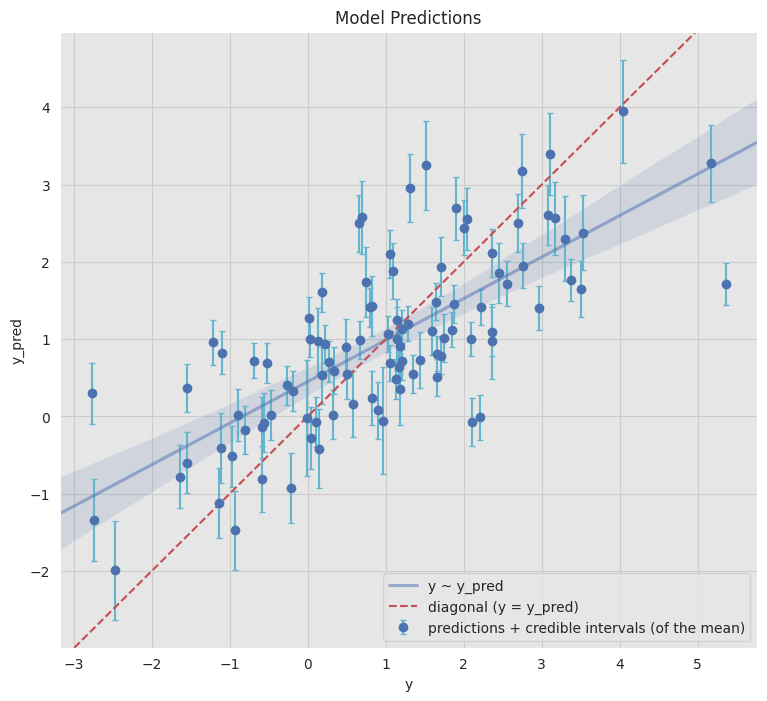

In [101]:
#PLot the results

mu_posterior_mean = tf.math.reduce_mean(mu_posterior_samples, axis=0).numpy()
mu_posterior_std = tf.math.reduce_std(mu_posterior_samples, axis=0).numpy()

fig, ax = plt.subplots(figsize=(9, 8))

ax.errorbar(x=tf.squeeze(y).numpy(),
            y=mu_posterior_mean,
            yerr=2*mu_posterior_std,
            fmt='o',
            ecolor=sns_c[9],
            capsize=2,
            label='predictions + credible intervals (of the mean)')

sns.regplot(x=tf.squeeze(y).numpy(),
            y=mu_posterior_mean,
            color = sns_c[0],
            scatter = False,
            line_kws = dict(alpha=0.5),
            label='y ~ y_pred',
            truncate = False,
            ax=ax)

ax.axline(xy1=(0,0), slope=1, linestyle='--', color=sns_c[3], label='diagonal (y = y_pred)')

ax.legend(loc='lower right')

ax.set(title='Model Predictions', xlabel='y', ylabel='y_pred')


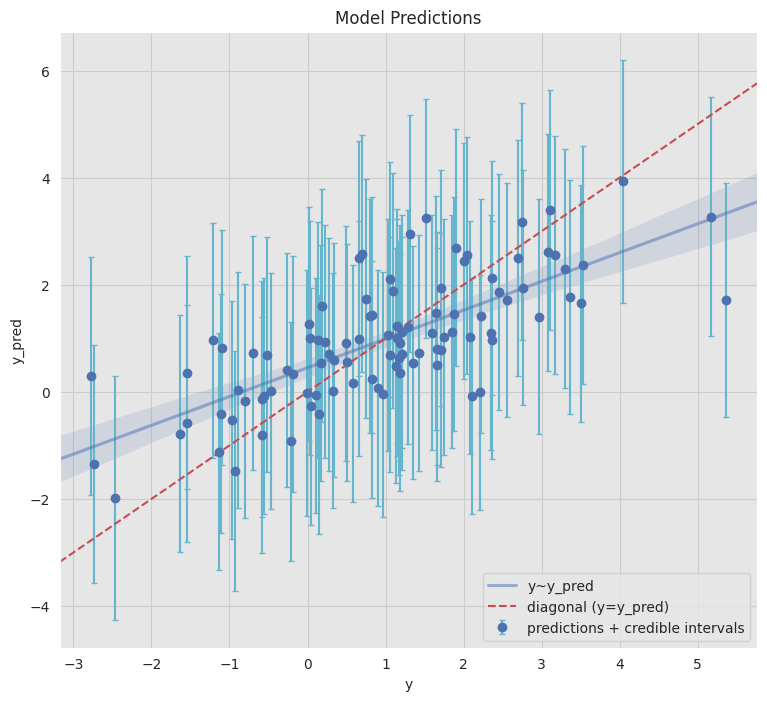

In [102]:
#Generate (in-sample) predictions by sampling from N(μ,σ).

pred_samples = tf.map_fn(
    fn=lambda z: tfd.Normal(loc=z, scale=chains_samples[2]).sample(1),
    elems=tf.transpose(mu_posterior_samples))

pred_samples = tf.squeeze(pred_samples)

posterior_mean = tf.math.reduce_mean(pred_samples, axis=1).numpy()

posterior_std = tf.math.reduce_std(pred_samples, axis=1).numpy()

fig, ax = plt.subplots(figsize=(9, 8))

ax.errorbar(x=tf.squeeze(y).numpy(),
            y=posterior_mean,
            yerr=2*posterior_std,
            fmt='o',
            ecolor=sns_c[9],
            capsize=2,
            label='predictions + credible intervals',)

sns.regplot(x=tf.squeeze(y).numpy(),
            y = mu_posterior_mean,
            color=sns_c[0],
            scatter=False,
            line_kws = dict(alpha=0.5),
            label='y~y_pred',
            truncate=False,
            ax=ax)

ax.axline(xy1=(0,0),
          slope=1,
          linestyle='--',
          color=sns_c[3],

          label='diagonal (y=y_pred)')

ax.legend(loc='lower right')

ax.set(title = 'Model Predictions', xlabel='y', ylabel='y_pred');


In [103]:
#Finally let us generate an out-sample. prediction for the vector

#x∗=(3
 #    1)

#Again, remember we are not interested in the point prediction
#but rather on the complete posterior distribution.


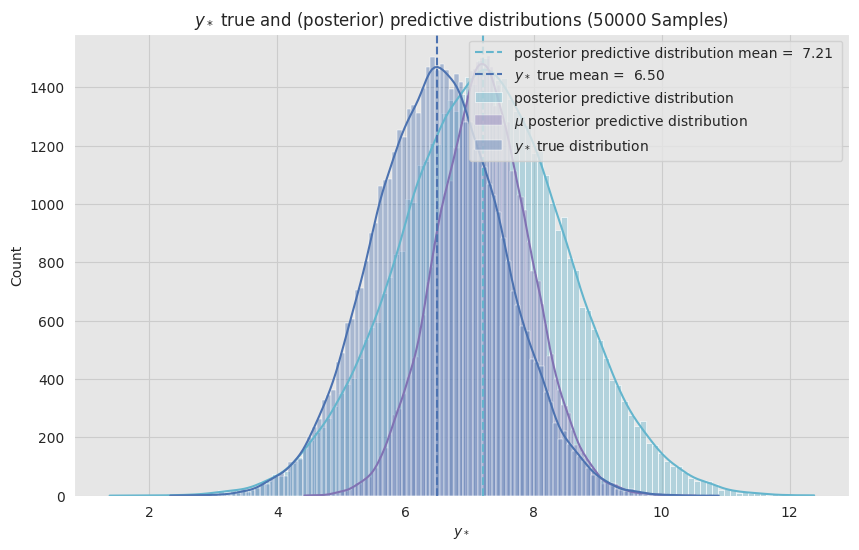

In [115]:
x_star = tf.cast([[3.0, 1.0]], dtype)

#Here we compute

#mu = alpha + beta x.
mu_y_star = tf.linalg.matmul(tf.reshape(chains_samples[1], (-1, 1)), tf.ones(shape=(1, x_star.shape[0])))\
    + tf.linalg.matmul(chains_samples[0], tf.transpose(x_star))

#Compyte posterior predictive distribution

y_star_samples = tf.map_fn(fn=lambda z: tfd.Normal(loc=z, scale=chains_samples[2]).sample(1), elems=tf.transpose(mu_y_star))

#Generate samples from the "true" distribution:

#Point prediction of the mean.

y_star_true = tf.linalg.matmul(x_star, tf.transpose(tf.cast([beta], dtype)))+alpha

y_star_true = y_star_true.numpy().flatten()

#sample from the complete posterior predictive distribution.

y_star_true_samples = tfd.Normal(loc=y_star_true, scale=sigma).sample(num_chains*num_results)

y_star_true_samples = y_star_true_samples.numpy().flatten()

#Mean of the complete posterior predictive distribution.
y_star_true_samples_mean = tf.reduce_mean(y_star_samples, axis=2).numpy().flatten()

#PLot the results

fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(x=tf.squeeze(y_star_samples).numpy(),
             kde=True,
             color=sns_c[9],
             alpha=0.4,
             label='posterior predictive distribution',
             ax=ax)

ax.axvline(x=y_star_true_samples_mean,
           color=sns_c[9],
           linestyle='--',
           label=f'posterior predictive distribution mean = {y_star_true_samples_mean[0]: 0.2f} ')

sns.histplot(x=mu_y_star.numpy().flatten(),
             kde=True,
             color=sns_c[4],
             alpha=0.4,
             label = '$\mu$ posterior predictive distribution',
             ax=ax)
sns.histplot(x=y_star_true_samples,
             kde=True,
             color = sns_c[0],
             alpha = 0.4,
             label='$y_*$ true distribution',
             ax=ax)

ax.axvline(x=y_star_true,
           color=sns_c[0],
           linestyle='--',
           label=f'$y_*$ true mean = {y_star_true[0]: 0.2f}')
ax.legend(loc='upper right')
ax.set(
   title=f'$y_*$ true and (posterior) predictive distributions ({num_chains*num_results} Samples)',
   xlabel = f'$y_*$');

In [ ]:
'''
The blue distribution is the “true” one which we get by sampling from N(μ∗,σ), where μ∗=α+βx∗ (known values of α and β).

The purple distribution is the one of the mean posterior samples of ^μ∗=^α+^βx∗.
Here ^α and ^β denote samples from the posterior.

The sky-blue distribution is the complete posterior predictive distribution, i.e. N(^μ∗,^σ2).
'''